In [ ]:
!pip install kagglehub[pandas-datasets]


In [ ]:
import os
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
import xgboost as xgb
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import torch
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud
import warnings
import string
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!unzip -o -q /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/trip-advisor-hotel-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/trip-advisor-hotel-reviews


In [ ]:
csv_path = os.path.join(path, "tripadvisor_hotel_reviews.csv")
df = pd.read_csv(csv_path, encoding="utf-8", encoding_errors="replace")

In [ ]:
df['Rating'].value_counts()


,count
Rating,
5,9054
4,6039
3,2184
2,1793
1,1421


In [ ]:
# df = df[df['Rating'] != 5]

In [ ]:
def label_sentiment(rating):
    if rating <= 3:
        return 'negative'
    else:
        return 'positive'

In [ ]:
df['sentiment'] = df['Rating'].apply(label_sentiment)
df.head(10)

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not 4* experience hotel monaco seat...,3,negative
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive
5,love monaco staff husband stayed hotel crazy w...,5,positive
6,"cozy stay rainy city, husband spent 7 nights m...",5,positive
7,"excellent staff, housekeeping quality hotel ch...",4,positive
8,"hotel stayed hotel monaco cruise, rooms genero...",5,positive
9,excellent stayed hotel monaco past w/e delight...,5,positive


In [ ]:
df['Rating'].value_counts()

,count
Rating,
5,9054
4,6039
3,2184
2,1793
1,1421


Data Visualization

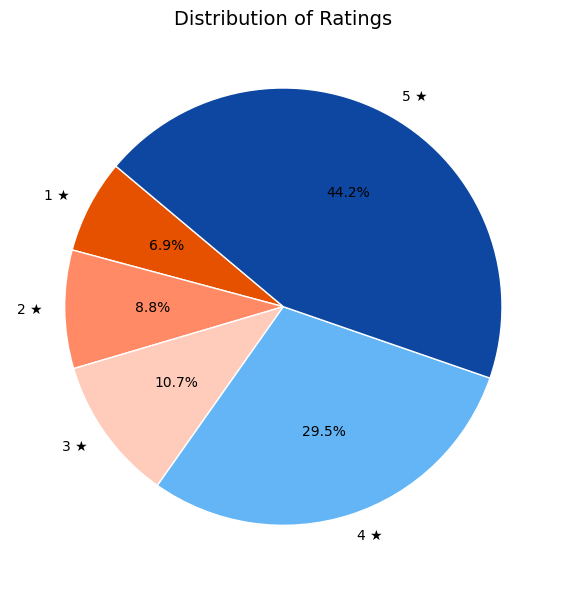

In [ ]:
# Thống kê tỉ lệ các rating
ratings_count = df['Rating'].value_counts(normalize=True).mul(100).sort_index()
labels = [f"{rating} ★" for rating in ratings_count.index]

# Màu theo rating (1 → 5): Cam đậm → cam nhạt → xanh nhạt → xanh đậm
custom_colors = {
    1: "#E65100",  # Cam đậm (tệ nhất)
    2: "#FF8A65",  # Cam vừa
    3: "#FFCCBC",  # Cam nhạt (gần trung lập)
    4: "#64B5F6",  # Xanh nhạt
    5: "#0D47A1"   # Xanh đậm (tốt nhất)
}
colors = [custom_colors[rating] for rating in ratings_count.index]

# Vẽ pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    ratings_count,
    labels=labels,
    autopct="%.1f%%",
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Distribution of Ratings", fontsize=14)
plt.tight_layout()
plt.show()


Distribution of review lengths for each rating

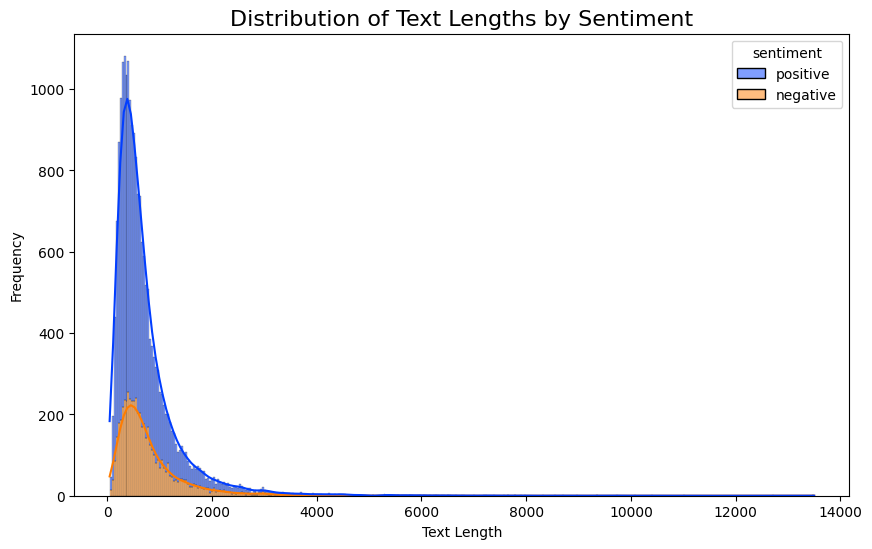

In [ ]:
# Calculate the length of each review
df['word_length'] = df['Review'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df, x='word_length', hue='sentiment', multiple='stack', palette='bright', kde=True)
plt.title('Distribution of Text Lengths by Sentiment', fontsize=16)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

<ipython-input-20-2802393521>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


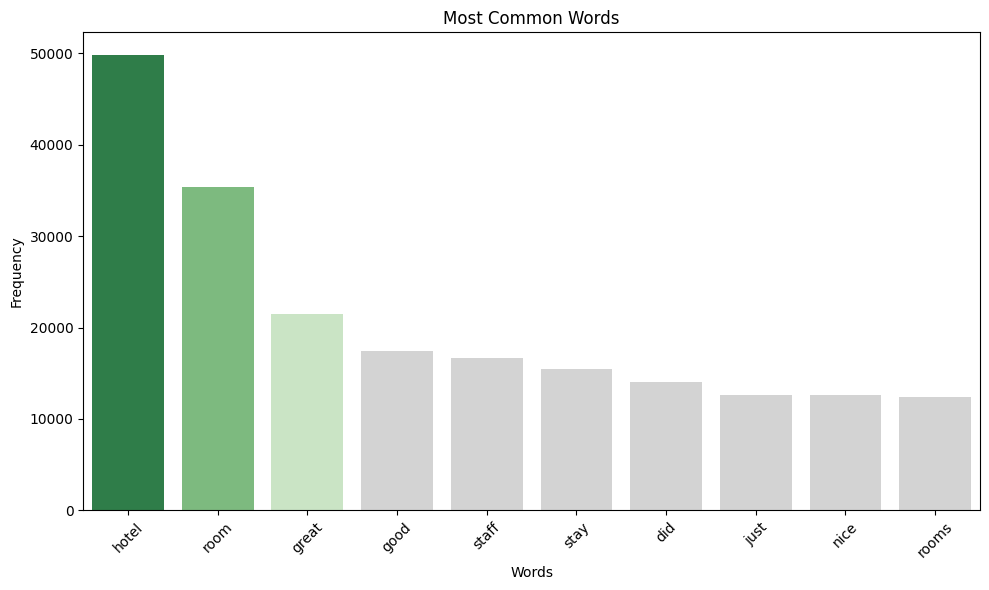

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Tạo CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=10)
word_counts = vectorizer.fit_transform(df['Review']).toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
word_freq = dict(zip(words, word_counts))
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

# Số lượng cột
num_bars = len(sorted_word_freq)

# Màu xanh lá cho top 3
green_palette = sns.color_palette("Greens", 3)[::-1]  # Đậm nhất đầu
# Màu xám cho phần còn lại
gray_palette = ["lightgray"] * (num_bars - 3)
# Kết hợp lại
final_palette = green_palette + gray_palette

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(sorted_word_freq.keys()),
    y=list(sorted_word_freq.values()),
    palette=final_palette
)

plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def show_wordcloud(reviews, title="Word Cloud"):
    wc = WordCloud(max_words=500, background_color="white").generate(" ".join(reviews))
    plt.figure(figsize=(10, 6))
    plt.imshow(wc)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

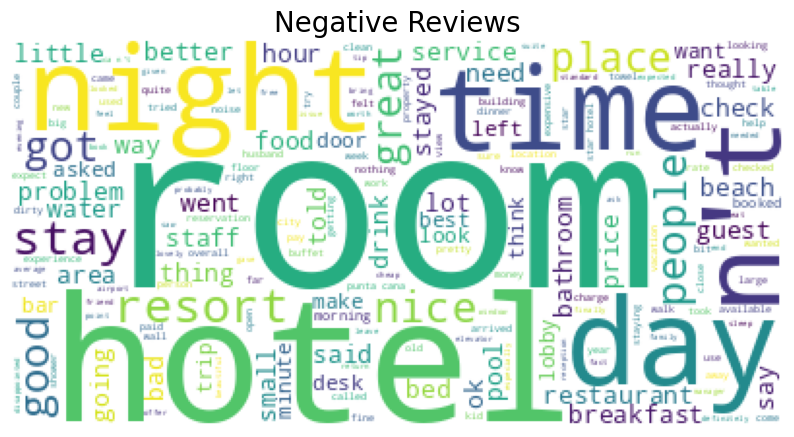

In [ ]:
show_wordcloud(df[df["sentiment"] == "negative"]["Review"], title="Negative Reviews")

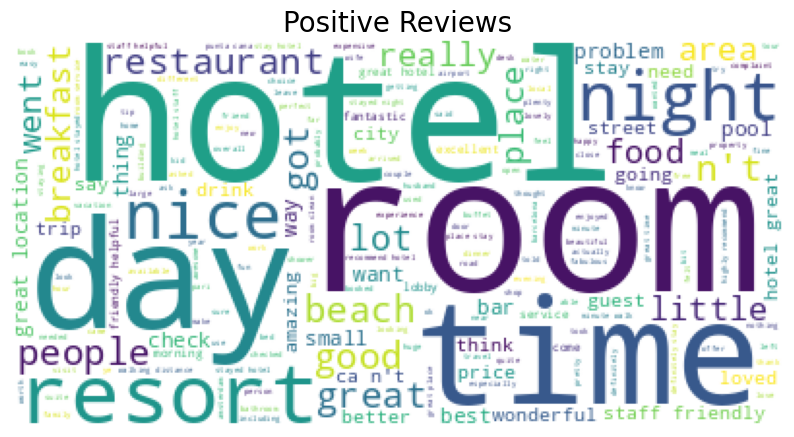

In [ ]:
show_wordcloud(df[df["sentiment"] == "positive"]["Review"], title="Positive Reviews")

II. Preprocess Data

In [ ]:
df

,Review,Rating,sentiment,word_length
0,nice hotel expensive parking got good deal sta...,4,positive,593
1,ok nothing special charge diamond member hilto...,2,negative,1689
2,nice rooms not 4* experience hotel monaco seat...,3,negative,1427
3,"unique, great stay, wonderful time hotel monac...",5,positive,600
4,"great stay great stay, went seahawk game aweso...",5,positive,1281
...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,positive,733
20487,great location price view hotel great quick pl...,4,positive,306
20488,"ok just looks nice modern outside, desk staff ...",2,negative,443
20489,hotel theft ruined vacation hotel opened sept ...,1,negative,5557


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Clean data and remove stopwords
clean_line = []
for line in df['Review']:
  cl_line = line.strip().lower()
  cl_line = ''.join(c for c in cl_line if c not in string.punctuation)
  cl_line = ''.join(c for c in cl_line if c.isascii())
  cl_line = ''.join(c for c in cl_line if c not in string.digits)
  cl_line = ' '.join(cl_line.split())
  words = cl_line.split()
  cl_line = ' '.join(word for word in words if word not in stop_words)
  cl_line = ' '.join(lemmatizer.lemmatize(word) for word in cl_line.split())
  clean_line.append(cl_line)

In [ ]:
df['Review'] = clean_line

In [ ]:
ecd = LabelEncoder()
df['sentiment'] = ecd.fit_transform(df['sentiment'])

In [ ]:
x = df['Review']
y = df['sentiment']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42, stratify=y)

In [ ]:
#c
vectorizer = TfidfVectorizer(stop_words="english")
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)


In [ ]:
# import pickle
# with open("vectorizer.pkl", "wb") as f:
#     pickle.dump(vectorizer, f)

In [ ]:
x_train.shape

(16392, 1285)

In [ ]:
# selector = SelectKBest(chi2, k=500)  # choose top 1000 features
# x_train = selector.fit_transform(x_train, y_train)
# x_test  = selector.transform(x_test)

In [ ]:
x_train.shape

(16392, 1285)

F1 Score: 0.93
ROC AUC Score: 0.83
Precision Score: 0.90
Recall Score: 0.95
Logistic Accuracy: 88.88 %
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      1080
           1       0.90      0.95      0.93      3019

    accuracy                           0.89      4099
   macro avg       0.87      0.83      0.85      4099
weighted avg       0.89      0.89      0.89      4099



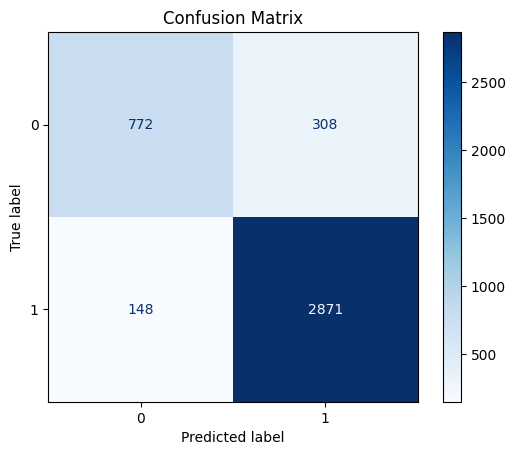

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score,
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Train logistic regression
logistic = LogisticRegression(random_state=42)

logistic.fit(x_train, y_train)

# Predict
y_pred = logistic.predict(x_test)

# Evaluation metrics
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2f}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2f}")
print(f"Logistic Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(logistic.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [ ]:
print(logistic.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


F1 Score: 0.93
ROC AUC Score: 0.86
Precision Score: 0.92
Recall Score: 0.94
SVC Accuracy: 89.70 %
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1080
           1       0.92      0.94      0.93      3019

    accuracy                           0.90      4099
   macro avg       0.87      0.86      0.87      4099
weighted avg       0.90      0.90      0.90      4099



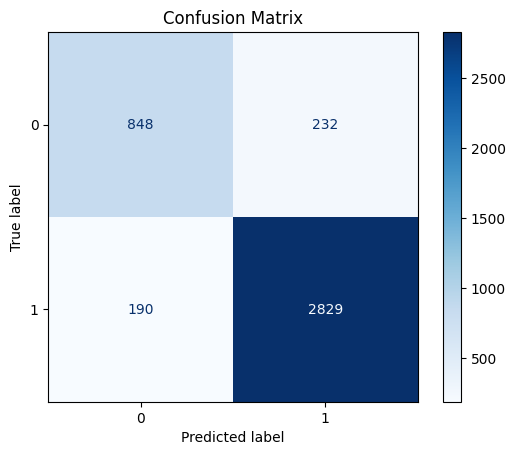

In [ ]:
svc = SVC(class_weight='balanced', random_state=42)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
# Evaluation metrics
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2f}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2f}")
print(f"SVC Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pickle
with open('support_vector.pkl', 'wb') as file:
    pickle.dump(svc, file)

In [ ]:
print(svc.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
print(svc.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


F1 Score: 0.91
ROC AUC Score: 0.76
Precision Score: 0.86
Recall Score: 0.97
Random Forest Accuracy: 85.66 %
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.55      0.67      1080
           1       0.86      0.97      0.91      3019

    accuracy                           0.86      4099
   macro avg       0.86      0.76      0.79      4099
weighted avg       0.86      0.86      0.85      4099



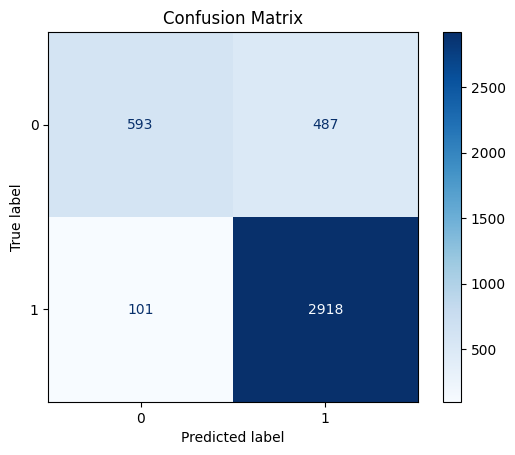

In [ ]:
random_forest = RandomForestClassifier(random_state=42, class_weight='balanced')
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
# Evaluation metrics
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2f}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(random_forest.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:32:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.91
ROC AUC Score: 0.76
Precision Score: 0.86
Recall Score: 0.97
XGB classifier Accuracy: 85.66 %
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.55      0.67      1080
           1       0.86      0.97      0.91      3019

    accuracy                           0.86      4099
   macro avg       0.86      0.76      0.79      4099
weighted avg       0.86      0.86      0.85      4099



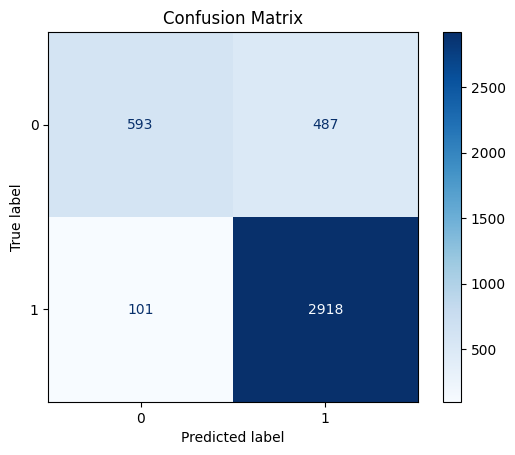

In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',  scale_pos_weight= 5398 / 15093, random_state=42)
model.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
# Evaluation metrics
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2f}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2f}")
print(f"XGB classifier Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(model.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 0.3576492413701716, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [ ]:
model = LogisticRegression(random_state=42)
model_1 = SVC()
model_2 = RandomForestClassifier(random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')




In [ ]:
params = { "n_estimators": [50,100,200],
            "criterion": ["gini", "entropy", "log_loss"],
            "max_depth": [10,20,30, None]}
tuning_forest = GridSearchCV(model_2, param_grid=params, cv=6, scoring = "precision", n_jobs = -1)
tuning_forest.fit(x_train, y_train)
print(tuning_forest.best_score_)

0.8188021377041057


In [ ]:
print('Precsision:', precision_score(y_test, tuning_forest.best_estimator_.predict(x_test)))

Precsision: 0.8222650868007716


In [ ]:
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'degree': [2, 3, 4],
              'gamma': ['scale', 'auto']}
tuning_svc = GridSearchCV(model_1, param_grid=param_grid, cv=6, scoring = "precision", n_jobs = -1)
tuning_svc.fit(x_train, y_train)
print(tuning_svc.best_score_)

In [ ]:
print('Precision', precision_score(y_test, tuning_svc.best_estimator_.predict(x_test)))

In [ ]:
param_logistic = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga', 'lbfgs'],
              'max_iter': [100, 200, 300, 400, 500]}
tuning_logistic = GridSearchCV(model, param_grid=param_logistic, cv=6, scoring = "precision", n_jobs= -1)
tuning_logistic.fit(x_train, y_train)
print('best_score: ',tuning_logistic.best_score_)
print('best_params: ',tuning_logistic.best_params_)

In [ ]:
print('Precision', precision_score(y_test, tuning_logistic.best_estimator_.predict(x_test)))